In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
from scipy.misc import imresize

%matplotlib inline

import os
from os import listdir
from os.path import isfile, join
import shutil
import stat
import collections
from collections import defaultdict

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

import h5py
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.applications.inception_v3 import preprocess_input
from keras.models import load_model

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Download dataset

In [7]:
!curl -O https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
 86 4764M   86 4101M    0     0  5343k      0  0:15:13  0:13:06  0:02:07 6225k^C


In [ ]:
# Unzip dataset
!tar xzvf food-101.tar.gz

In [ ]:
!ls food-101/images

In [2]:
class_to_ix = {}
ix_to_class = {}
with open('food-101/meta/classes.txt', 'r') as txt:
    classes = [l.strip() for l in txt.readlines()]
    class_to_ix = dict(zip(classes, range(len(classes))))
    ix_to_class = dict(zip(range(len(classes)), classes))
    class_to_ix = {v: k for k, v in ix_to_class.items()}
sorted_class_to_ix = collections.OrderedDict(sorted(class_to_ix.items()))
class_to_ix

{'foie_gras': 0,
 'club_sandwich': 1,
 'cheese_plate': 2,
 'garlic_bread': 3,
 'gnocchi': 4,
 'ice_cream': 5,
 'samosa': 6,
 'donuts': 7,
 'tuna_tartare': 8,
 'filet_mignon': 9,
 'seaweed_salad': 10,
 'french_toast': 11,
 'chicken_curry': 12,
 'shrimp_and_grits': 13,
 'steak': 14,
 'cheesecake': 15,
 'red_velvet_cake': 16,
 'waffles': 17,
 'gyoza': 18,
 'lobster_roll_sandwich': 19,
 'huevos_rancheros': 20,
 'breakfast_burrito': 21,
 'grilled_cheese_sandwich': 22,
 'falafel': 23,
 'greek_salad': 24,
 'beef_tartare': 25,
 'fried_calamari': 26,
 'guacamole': 27,
 'lobster_bisque': 28,
 'beet_salad': 29,
 'risotto': 30,
 'crab_cakes': 31,
 'strawberry_shortcake': 32,
 'edamame': 33,
 'hot_and_sour_soup': 34,
 'spring_rolls': 35,
 'sashimi': 36,
 'clam_chowder': 37,
 'miso_soup': 38,
 'escargots': 39,
 'hot_dog': 40,
 'pulled_pork_sandwich': 41,
 'bruschetta': 42,
 'panna_cotta': 43,
 'fish_and_chips': 44,
 'pad_thai': 45,
 'tiramisu': 46,
 'takoyaki': 47,
 'macarons': 48,
 'apple_pie': 49,

In [ ]:
def load_images_paths(root, min_side=299):
    files = []
    classes = []
    for i, subdir in enumerate(listdir(root)):
#         class_ix = class_to_ix[subdir]
        if subdir == '.DS_Store':
            continue
        imgs = listdir(join(root, subdir))
#         print(i, class_ix, subdir)
        for img_name in imgs:
            img_path = join(root, subdir, img_name)
            files.append((img_path, class_to_ix[subdir]))
    return files
load_images_paths('food-101/images')

In [4]:
from keras.utils.np_utils import to_categorical

n_classes = len(class_to_ix)

In [5]:
%%time

# Load dataset images and resize to meet minimum width and height pixel size    
def loadImageFiles(files):
    all_imgs = []
    all_classes = []
    resize_count = 0
    invalid_count = 0
    min_side = 299
    for (filepath, file_class) in files:
        img_arr = img.imread(filepath)
        img_arr_rs = img_arr
        try:
            w, h, _ = img_arr.shape
#             print(w, ' ', h)
            if w < min_side:
                wpercent = (min_side/float(w))
                hsize = int((float(h)*float(wpercent)))
#                 print('new dims:', min_side, hsize)
                img_arr_rs = imresize(img_arr, (min_side, hsize))
                resize_count += 1
            elif h < min_side:
                hpercent = (min_side/float(h))
                wsize = int((float(w)*float(hpercent)))
#                 print('new dims:', wsize, min_side)
                img_arr_rs = imresize(img_arr, (wsize, min_side))
                resize_count += 1
            reshaped_img = imresize(img_arr_rs, (299, 299, 3))
            all_imgs.append(reshaped_img)
            all_classes.append(file_class)
        except:
            print('Skipping bad image: ', filepath)
            invalid_count += 1
    print(len(all_imgs), 'images loaded')
    print(resize_count, 'images resized')
    print(invalid_count, 'images skipped')
    return np.array(all_imgs), np.array(all_classes)

def imageLoader(files, batch_size):
    L = len(files)

    #this line is just to make the generator infinite, keras needs that    
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
            X, Y = loadImageFiles(files[batch_start:limit])
            categorical_Y = to_categorical(Y, n_classes)
#             print('X_train shape', X.shape)
#             print('y_train shape', categorical_Y.shape)
            yield (X,categorical_Y) #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   
            batch_end += batch_size
filepaths = load_images_paths('food-101/images')
batch_size = 128
loader = imageLoader(filepaths, batch_size)
# X_test, y_test = load_images('food-101/test', min_side=299)

CPU times: user 245 ms, sys: 119 ms, total: 363 ms
Wall time: 461 ms


In [6]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.layers import Input

In [7]:
%%time
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, ReduceLROnPlateau
from keras.optimizers import SGD
from keras.regularizers import l2
import keras.backend as K
import math

size = 101000

K.clear_session()

base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=Input(shape=(299, 299, 3)))
x = base_model.output
x = AveragePooling2D(pool_size=(8, 8))(x)
x = Dropout(.4)(x)
x = Flatten()(x)
predictions = Dense(n_classes, init='glorot_uniform', W_regularizer=l2(.0005), activation='softmax')(x)

model = Model(input=base_model.input, output=predictions)

opt = SGD(lr=.01, momentum=.9)
model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='model4.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('model4.log')

def schedule(epoch):
    if epoch < 15:
        return .01
    elif epoch < 28:
        return .002
    else:
        return .0004
lr_scheduler = LearningRateScheduler(schedule)

CPU times: user 17 s, sys: 591 ms, total: 17.6 s
Wall time: 17.5 s


/Users/jasonjin/Desktop/Swat/CS/65/FinalProject-hhan3-jjin3/venv/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(88, activation="softmax", kernel_initializer="glorot_uniform", kernel_regularizer=<keras.reg...)`
/Users/jasonjin/Desktop/Swat/CS/65/FinalProject-hhan3-jjin3/venv/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [96]:
from keras_tqdm import TQDMNotebookCallback

## NOTE: For the purposes of the workshop, we're just doing 5 steps per epoch and 2 epochs. You most likely need far more epochs, and the # of steps per epoch is generally calculated by "dataset_size/batch_size"


In [ ]:
history = model.fit_generator(loader,
                    steps_per_epoch=5,
                    epochs=1,
                    verbose=0,
                    callbacks=[TQDMNotebookCallback()])

class: 0 foie_gras


array([[[185, 159, 136],
        [187, 161, 138],
        [189, 165, 141],
        ...,
        [175, 152, 134],
        [172, 149, 131],
        [169, 146, 128]],

       [[189, 163, 140],
        [191, 165, 142],
        [192, 166, 143],
        ...,
        [175, 152, 134],
        [172, 149, 131],
        [169, 146, 128]],

       [[194, 168, 145],
        [194, 168, 145],
        [194, 167, 146],
        ...,
        [176, 153, 135],
        [174, 151, 133],
        [172, 149, 131]],

       ...,

       [[169, 140, 108],
        [171, 142, 110],
        [174, 145, 113],
        ...,
        [150, 126,  88],
        [152, 130,  91],
        [157, 135,  96]],

       [[173, 144, 112],
        [171, 142, 110],
        [173, 144, 112],
        ...,
        [150, 126,  88],
        [151, 127,  89],
        [155, 131,  93]],

       [[174, 145, 113],
        [170, 141, 109],
        [170, 141, 109],
        ...,
        [152, 128,  90],
        [151, 127,  89],
        [153, 129,  91]]

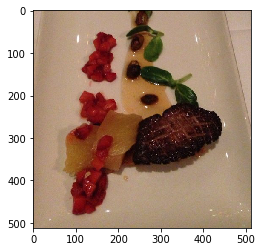

In [23]:
# def load_image(filepath):
def show_pic(n):
    img = plt.imread(filepaths[n][0])
    plt.imshow(img)
    print('class:', filepaths[n][1], ix_to_class[filepaths[n][1]])
    return img
show_pic(100)

In [22]:
n = 100

In [24]:
x_test = img.imread(filepaths[n][0])
y_test, y_test_label = filepaths[n][1], ix_to_class[filepaths[n][1]]

In [25]:
def reshapeImg(orig_img_arr, min_side=299):
    w, h, _ = orig_img_arr.shape
    img_arr_rs = orig_img_arr;
#             print(w, ' ', h)
    if w < min_side:
        wpercent = (min_side/float(w))
        hsize = int((float(h)*float(wpercent)))
#                 print('new dims:', min_side, hsize)
        img_arr_rs = imresize(img_arr, (min_side, hsize))
        resize_count += 1
    elif h < min_side:
        hpercent = (min_side/float(h))
        wsize = int((float(w)*float(hpercent)))
#                 print('new dims:', wsize, min_side)
        img_arr_rs = imresize(orig_img_arr, (wsize, min_side))
        resize_count += 1
    reshaped_img = imresize(img_arr_rs, (299, 299, 3))
    return reshaped_img

In [26]:
x_test = reshapeImg(x_test)
np.asarray([x_test]).shape

/Users/jasonjin/Desktop/Swat/CS/65/FinalProject-hhan3-jjin3/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


(1, 299, 299, 3)

In [27]:
top_n = 5
y_pred = model.predict(np.asarray([x_test]))
preds = np.argmax(y_pred, axis=1)
top_n_preds= np.argpartition(y_pred, -top_n)[:,-top_n:]
print('Top-1 Predicted:', preds)
print('Top-5 Predicted:', top_n_preds)
print('True Label:', y_test, y_test_label)

Top-1 Predicted: [53]
Top-5 Predicted: [[63 12 41 53 30]]
True Label: 0 foie_gras


In [ ]:
# from keras.models import model_from_json

# # Model reconstruction from JSON file
# with open('model4b.10-0.68_weights.buf', 'r') as f:
#     model.load_weights(f)

#     model = model_from_json(f.read())

model.load_weights('model4b.10-0.68_weights.hdf5')
